In [1]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
import os
from tensorflow.contrib.tensorboard.plugins import projector
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import roc_auc
from sklearn.base import BaseEstimator

In [47]:
def fit(sess, _train_data, param, graph=False):
    num_of_sequence_length = len(_train_data[0])
    num_of_hidden_nodes = param['num_of_hidden_nodes']
    num_of_training_epochs = param['num_of_training_epochs']
    size_of_mini_batch = param['size_of_mini_batch']
    size_of_test_batch = param['size_of_test_batch']
    learning_rate = param['learning_rate']
    
    random.seed(0)
    np.random.seed(0)
    tf.set_random_seed(0)

    input_ph      = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_sequence_length], name="supervisor")
    batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    with tf.name_scope("inference") as scope:
        weight_var = tf.Variable(tf.truncated_normal([num_of_sequence_length, num_of_hidden_nodes], stddev=0.1), name="weight")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_sequence_length], stddev=0.1), name="bias2")
        hidden = tf.sigmoid(tf.matmul(input_ph, weight_var) + bias1_var)
        output_op = tf.sigmoid(tf.matmul(hidden, tf.transpose(weight_var) + bias2_var))

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    init = tf.global_variables_initializer()

    sess.run(init)
    accuracy_results = []

    for epoch in range(num_of_training_epochs):
        train_dict = {
            input_ph: _train_data,
            supervisor_ph: _train_data,
            batch_size_ph: size_of_mini_batch,
        }
        sess.run(training_op, feed_dict=train_dict)

        if (epoch + 1) % 10 == 0:
            train_loss = sess.run(loss_op, feed_dict=train_dict)

            # eval accuracy
            pred_dict = {
                input_ph: _train_data,
                supervisor_ph: _train_data,
                batch_size_ph: size_of_test_batch,
            }
            accuracy_results.append([epoch, train_loss])
            preddata = sess.run(output_op, feed_dict=pred_dict)
            #print("train#%d, train loss: %e" % (epoch + 1, train_loss))
    
    if graph == True:
        df = pd.DataFrame({
            'epoch': [x[0] for x in accuracy_results],
            'train_loss': [x[1] for x in accuracy_results]
        })
        df.plot(x='epoch', y='train_loss')
        df.head()
    
    return (input_ph, supervisor_ph, batch_size_ph), loss_op

In [3]:
def decision_function(sess, data, ph, loss):
    num_of_sequence_length = len(data[0])
    
    input_ph,  supervisor_ph, batch_size_ph = ph
    loss_op = loss
    
    _train_data = data
    
    scores = []
    
    for epoch in range(len(_train_data)):
        data = _train_data[epoch].reshape(-1, num_of_sequence_length)

        train_dict = {
            input_ph: data,
            supervisor_ph: data,
            batch_size_ph: 1,
        }

        train_loss = sess.run(loss_op, feed_dict=train_dict)
        scores.append(train_loss)
        #print('test w/ train #.%d %f' % (epoch, train_loss))
        
    return scores

In [4]:
class EstimatorNN(BaseEstimator):
    def __init__(self, num_of_hidden_nodes=20, num_of_training_epochs=100, size_of_mini_batch=10,
                 size_of_test_batch=10, learning_rate=0.02):
        self.param = {}
        self.param['num_of_hidden_nodes'] = num_of_hidden_nodes
        self.param['num_of_training_epochs'] = num_of_training_epochs
        self.param['size_of_mini_batch'] = size_of_mini_batch
        self.param['size_of_test_batch'] = size_of_test_batch
        self.param['learning_rate'] = learning_rate
        self.g = tf.Graph()
        self.g.as_default()
        self.sess = tf.Session()
    
    def fit(self, x, graph=False):
        self.ph, self.loss = fit(self.sess, x, self.param, graph=graph)
        return self 

    def predict(self, x):
        return [1.0]*len(x) 
    
    def decision_function(self, x, y=None):
        data = decision_function(self.sess, x, self.ph, self.loss)
        return data

    def score(self, x, y=None):
        scores = self.decision_function(x)
        return sum(scores)/len(scores)

    def get_params(self, deep=True):
        return self.param

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self
    
    def get_type(self):
        return 'NN'
    
    def __del__(self):
        if hasattr(self, 'sess'):
            self.sess.close()
            del self.sess
            del self.g
            tf.reset_default_graph()

In [12]:
#''' pred area judgement from rssi
def test():
    train_data = np.array([[-50., -50., -50., -51., -49., -47., -45., -44., -45., -49.],
                           [-53., -53., -53., -53., -51., -50., -50., -51., -52., -52.],
                           [-54., -54., -54., -53., -52., -50., -48., -48., -47., -46.],
                           [-49., -47., -46., -45., -44., -44., -42., -41., -41., -41.]])
    test_data = np.array([[-63., -63., -64., -64., -63., -63., -63., -63., -63., -62.],
                          [-58., -59., -59., -59., -61., -61., -59., -56., -55., -54.],
                          [-65., -62., -62., -62., -61., -61., -60., -59., -60., -60.],
                          [-61., -61., -62., -62., -62., -61., -60., -61., -60., -60.]])
    print(train_data)
    print(test_data)
    train_data *= -0.01
    test_data *= -0.01

    nn = EstimatorNN()
    nn.fit(train_data)
    print(nn.decision_function(train_data))
    print(nn.decision_function(test_data))
    del nn
#test()

[[-50. -50. -50. -51. -49. -47. -45. -44. -45. -49.]
 [-53. -53. -53. -53. -51. -50. -50. -51. -52. -52.]
 [-54. -54. -54. -53. -52. -50. -48. -48. -47. -46.]
 [-49. -47. -46. -45. -44. -44. -42. -41. -41. -41.]]
[[-63. -63. -64. -64. -63. -63. -63. -63. -63. -62.]
 [-58. -59. -59. -59. -61. -61. -59. -56. -55. -54.]
 [-65. -62. -62. -62. -61. -61. -60. -59. -60. -60.]
 [-61. -61. -62. -62. -62. -61. -60. -61. -60. -60.]]
[0.00014519862, 0.0011018638, 0.00049376197, 0.0018677022]
[0.018546242, 0.008342701, 0.013882798, 0.013572408]
dell


In [31]:
ds = datasets.load('data/raw/02_1[14]_0*')

path = data/raw/02_1[14]_0*
data/raw/02_11_01_エネマネハウス_iphone_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/02_11_02_エネマネハウス_iphone_カバン_裏上_正常_まっすぐ帰宅
..............................
data/raw/02_11_03_エネマネハウス_iphone_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
..............................
data/raw/02_11_04_エネマネハウス_iphone_カバン_裏上_正常_5秒後まっすぐ帰宅
..............................
data/raw/02_14_01_エネマネハウス_iphone_胸ポケット_裏上_異常_エリア境界で静止
..............................
data/raw/02_14_02_エネマネハウス_iphone_カバン_裏上_異常_エリア境界で静止
..............................


n hidden: 2
--normal score
[2.0271249, 0.17197292, 0.015961748, 0.33186942, 0.0034121468, 2.1723421, 0.65468496, 0.061213691, 0.66339427, 0.13800541, 0.055455912, 0.7012856, 0.050562155, 0.083376855, 1.0826982, 2.1302102, 0.17266971, 0.083491392, 0.065945856, 0.034978453, 0.68356466, 0.21420936, 0.85278386, 0.36405632, 0.43124232, 0.52047962, 0.31242216, 0.50461811, 0.73267907, 0.10132289, 0.11897439, 1.6769689, 0.38194811, 0.59327602, 0.23920612, 1.9485213, 0.20074947, 0.55816489, 0.098865867, 0.42881683, 0.93384451, 0.07863488, 0.26120192, 0.67900079, 0.30651361, 0.53766268, 1.284983, 0.95332813, 0.11059004, 0.1821899, 0.65583271, 0.26472563, 0.63668293, 0.93954188, 2.0451801, 0.57177097, 0.56855011, 0.74699831, 0.29334834, 1.8857213, 0.11494819, 0.011838225, 0.054858942, 0.81001973, 0.4222931, 0.057364911, 0.1164507, 0.38616583, 0.078431375, 0.093252577, 0.074633956, 0.48021689, 1.2247287, 0.030830704, 0.013318305, 0.097118378, 1.1305293, 0.060596455, 0.50334102, 0.090788089, 0.0566

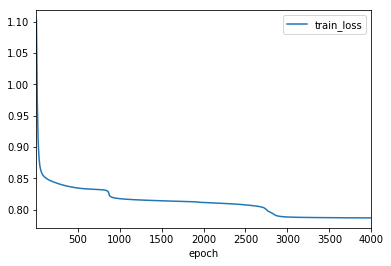

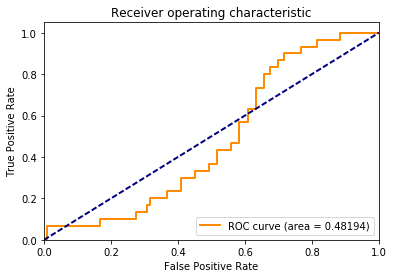

auc 0.48194


In [53]:
def eval01():
    #sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']]
    
    #sensor_type = ['rssi.a','rssi.b', ['gyro.rotation.x','gyro.rotation.y','gyro.rotation.z']]
    #sensor_type = ['rssi.a','rssi.b', ['gyro.rotationRate.x','gyro.rotationRate.y','gyro.rotationRate.z']]
    #sensor_type = ['rssi.a','rssi.b', ['userAcceleration.x','userAcceleration.y','userAcceleration.z']]
    #sensor_type = [['attitude.roll', 'attitude.pitch', 'attitude.yaw'], ['magneticField.x', 'magneticField.y', 'magneticField.z']]

    #sensor_type = [['magneticField.x', 'magneticField.y', 'magneticField.z']]

    sensor_type = ['rssi.a','rssi.b']
    n_record = 0
    n_record_after = 5
    drop_interval = 1
    ma_window = 1
    n_train = 5
    normalize = True
    
    # get data
    dfl_b = datasets.get_data(ds, title='02_11_01', before=n_record, after=n_record_after,
                              column=sensor_type, drop_interval=drop_interval)[:(n_train + 1)]
    dfl_n = datasets.get_data(ds, title='02_11', before=n_record, after=n_record_after,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title='02_14_02', before=n_record, after=n_record_after,
                              column=sensor_type, drop_interval=drop_interval)
    
    #dfl_o = dfl_o[:1]
    
    #print(dfl_o)
    #print(dfl_n)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = EstimatorNN(num_of_hidden_nodes=2, num_of_training_epochs=4000, size_of_mini_batch=10)
    model.fit(data_b, graph=True)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    
    print('--normal score')
    print(score_n)
    print('--anomaly score')
    print(score_o)
    
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)

    print('auc %.05f' % (auc))

eval01()